In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


テキストの挿入

In [ ]:
!pwd

/content


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Trial

/content/drive/MyDrive/Colab Notebooks/Trial


In [ ]:
!pwd

/content/drive/MyDrive/Colab Notebooks/Trial


In [ ]:
#%run prepare_images.py datasets/dice_top_crop

Copied images from datasets/dice_top_crop/1
Copied images from datasets/dice_top_crop/2
Copied images from datasets/dice_top_crop/3
Copied images from datasets/dice_top_crop/4
Copied images from datasets/dice_top_crop/5
Copied images from datasets/dice_top_crop/6


In [ ]:
#%cd datasets/dice_top_crop/1

/content/drive/My Drive/Colab Notebooks/Trial/datasets/dice_top_crop/1


In [ ]:
#!ls

IMG_20210418_174644.jpg  IMG_20210418_180532.jpg  IMG_20210418_180552.jpg
IMG_20210418_174655.jpg  IMG_20210418_180536.jpg  IMG_20210418_180555.jpg
IMG_20210418_174712.jpg  IMG_20210418_180539.jpg  IMG_20210418_180557.jpg
IMG_20210418_174728.jpg  IMG_20210418_180543.jpg  IMG_20210418_180600.jpg
IMG_20210418_175049.jpg  IMG_20210418_180546.jpg
IMG_20210418_175052.jpg  IMG_20210418_180549.jpg


In [ ]:
#%cd ../2

/content/drive/My Drive/Colab Notebooks/Trial/datasets/dice_top_crop/2


In [ ]:
#!ls

In [ ]:
#ファイル数カウント
import os
 
dir = '/content/drive/My Drive/Colab Notebooks/Trial/datasets/dice_top_crop/1'
count_file = 0
 
#ディレクトリの中身分ループ
for file_name in os.listdir(dir):
 
  #ファイルもしくはディレクトリのパスを取得
  file_path = os.path.join(dir,file_name)
 
  #ファイルであるか判定
  if os.path.isfile(file_path):
    count_file +=1
 
print(count_file)

16


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import shutil
import math
from IPython.display import Image as IPImage
from IPython.display import display_jpeg
import visualize

print(tf.__version__)

train_dir = 'target_datasets/train'
val_dir = 'target_datasets/val'

backup_dir = './model'

labels = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
labels.sort()

if os.path.exists(backup_dir):
    shutil.rmtree(backup_dir)

os.makedirs(backup_dir)

with open(backup_dir + '/labels.txt','w') as f:
    for label in labels:
        f.write(label+"\n")

NUM_CLASSES = len(labels)
print("class number=" + str(NUM_CLASSES))

labels = []
with open(backup_dir + '/labels.txt','r') as f:
    for line in f:
        labels.append(line.rstrip())
print(labels)

2.7.0
class number=3
['full', 'green', 'half']


Found 79 images belonging to 3 classes.
Found 21 images belonging to 3 classes.
## Train Data Sample ##


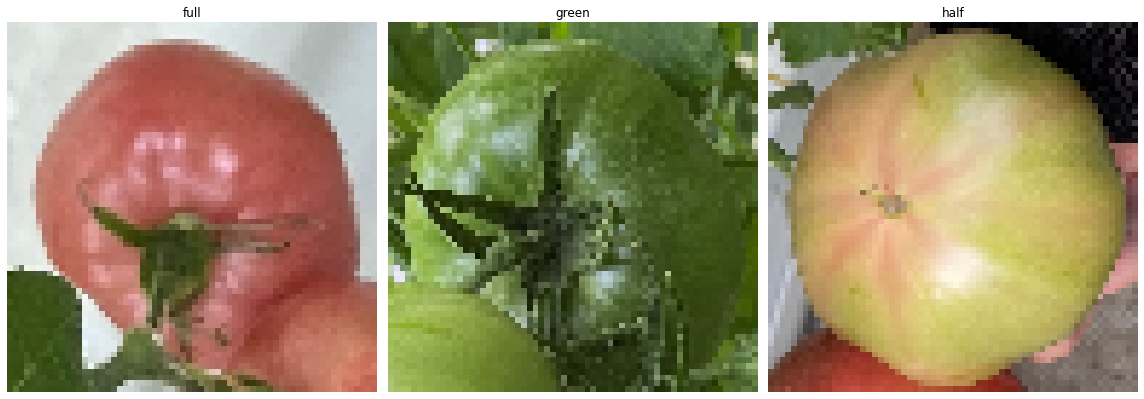

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_62 (Conv2D)          (None, 64, 64, 16)        448       
                                                                 
 activation_102 (Activation)  (None, 64, 64, 16)       0         
                                                                 
 conv2d_63 (Conv2D)          (None, 62, 62, 16)        2320      
                                                                 
 activation_103 (Activation)  (None, 62, 62, 16)       0         
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 31, 31, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_64 (Conv2D)          (None, 29, 29, 32)        4640      
                                                     

In [ ]:
# 学習率
LEARNING_RATE = 0.0005 #best0.0001
# エポック（世代数）
EPOCHS = 24 #best96
# バッチサイズ
BATCH_SIZE = 16

IMAGE_SIZE = 64

train_data_gen = ImageDataGenerator(rescale=1./255)
#train_data_gen = ImageDataGenerator(rescale=1./255, rotation_range=180)
val_data_gen = ImageDataGenerator(rescale=1./255)

# メモ：ImageDataGenerator.flow_from_directory はIteratorを返す
train_data = train_data_gen.flow_from_directory(
    train_dir, target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode='rgb', batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=True)

validation_data = val_data_gen.flow_from_directory(
    val_dir, target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode='rgb', batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False)

# Display train data sample
visualize.pick_train_sample(labels, train_data)

# AI model definition
model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', #best16
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
#model.add(BatchNormalization(name='bn1'))
model.add(Activation('relu'))
model.add(Conv2D(16, (3, 3)))  #best16
#model.add(BatchNormalization(name='bn2'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3)))
#model.add(BatchNormalization(name='bn3'))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
#model.add(BatchNormalization(name='bn4'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES))
model.add(Activation('softmax'))

opt = tf.keras.optimizers.Adam(lr=LEARNING_RATE)
#opt = tf.keras.optimizers.SGD(lr=LEARNING_RATE)

model.compile(opt, loss='categorical_crossentropy',
    metrics=['accuracy'])

model.summary()

# Execute train
history = model.fit(train_data, epochs=EPOCHS, validation_data=validation_data, verbose=1)

score = model.evaluate(validation_data)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Prediction data
[[0.746 0.    0.254]
 [0.5   0.    0.5  ]
 [0.99  0.    0.01 ]
 [1.    0.    0.   ]
 [1.    0.    0.   ]
 [0.988 0.    0.012]
 [0.998 0.    0.002]
 [0.    0.99  0.01 ]
 [0.    0.973 0.026]
 [0.    0.999 0.001]
 [0.    0.976 0.024]
 [0.    0.991 0.009]
 [0.    0.998 0.002]
 [0.    0.99  0.01 ]
 [0.    0.    1.   ]
 [0.373 0.    0.627]
 [0.307 0.    0.693]
 [0.    0.018 0.981]
 [0.    0.007 0.993]
 [0.036 0.001 0.964]
 [0.05  0.006 0.944]]
(21, 3)
#0 Expected:full -> Predicted:full
File: full/IMG_1070.jpg
Each Prediction Value: [0.746 0.    0.254]
* Correct *
#1 Expected:full -> Predicted:full
File: full/IMG_1071.jpg
Each Prediction Value: [0.5 0.  0.5]
* Correct *
#2 Expected:full -> Predicted:full
File: full/IMG_1073.jpg
Each Prediction Value: [0.99 0.   0.01]
* Correct *
#3 Expected:full -> Predicted:full
File: full/IMG_1074.jpg
Each Prediction Value: [1. 0. 0.]
* Correct *
#4 Expected:full -> Predicted:full
File: full/IMG_1075.jpg
Each Prediction Value: [1. 0. 0.]
* C

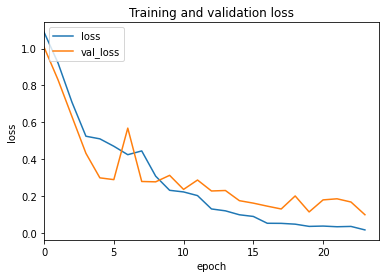

Accuracy


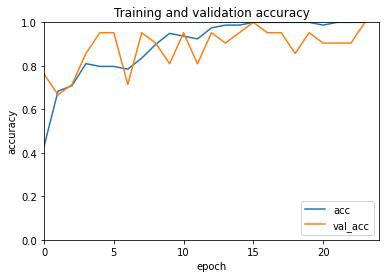

Confusion Matrix


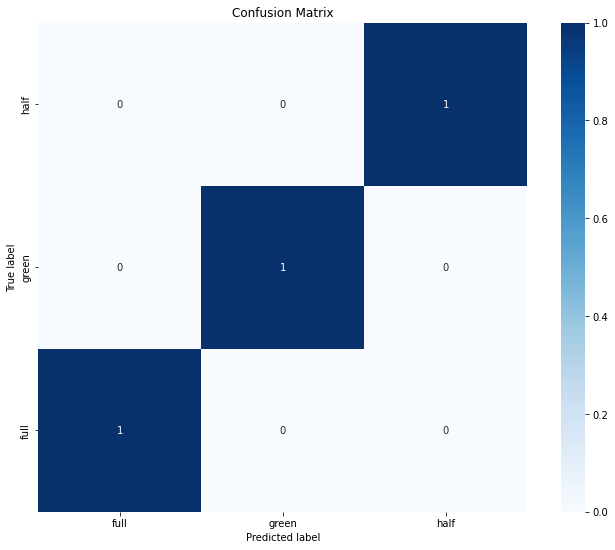

In [ ]:
# Failed pictures
visualize.vis_failed_pic(model, labels, validation_data, val_dir, BATCH_SIZE, 100)

# Visualize loss
visualize.vis_loss_accuracy(history, EPOCHS)

# Save model
save_model_path = os.path.join(backup_dir, 'my_model.h5')
model.save(save_model_path)

# Confusion Matrix
visualize.vis_confusion_matrix(model, validation_data)

Visualize filter: conv2d


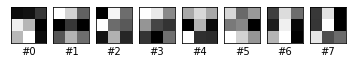

Visualize filter: conv2d_1


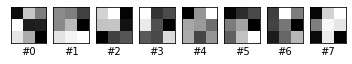

In [ ]:
visualize.vis_filter(model, 'conv2d')
visualize.vis_filter(model, 'conv2d_1')

In [ ]:
!cat incorrect.txt

target_datasets/val/half/IMG_1068.jpg
target_datasets/val/half/IMG_1072.jpg


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 8)         224       
                                                                 
 activation (Activation)     (None, 64, 64, 8)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 8)         584       
                                                                 
 activation_1 (Activation)   (None, 62, 62, 8)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 8)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 7688)              0         
                                                        

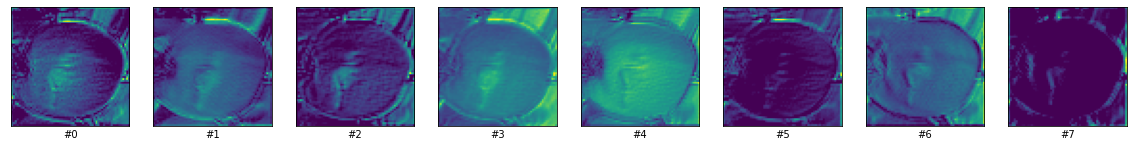

target_datasets/val/half/IMG_1072.jpg


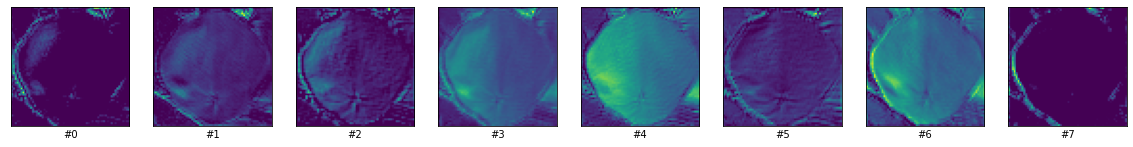

In [ ]:
visualize.vis_hidden_layer('incorrect.txt', 'activation_1', IMAGE_SIZE)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 8)         224       
                                                                 
 activation (Activation)     (None, 64, 64, 8)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 8)         584       
                                                                 
 activation_1 (Activation)   (None, 62, 62, 8)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 8)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 7688)              0         
                                                        

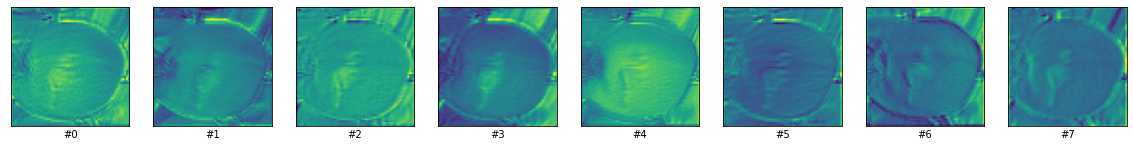

target_datasets/val/half/IMG_1072.jpg


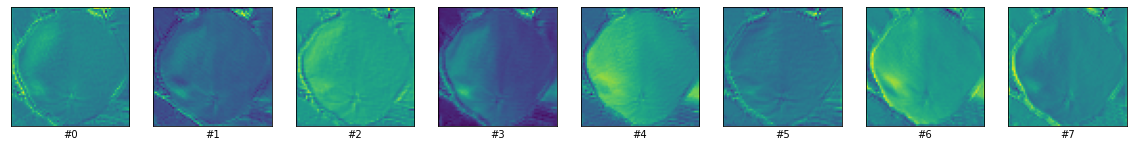

In [ ]:
visualize.vis_hidden_layer('incorrect.txt', 'conv2d_1', IMAGE_SIZE)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 8)         224       
                                                                 
 activation (Activation)     (None, 64, 64, 8)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 8)         584       
                                                                 
 activation_1 (Activation)   (None, 62, 62, 8)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 8)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 7688)              0         
                                                        

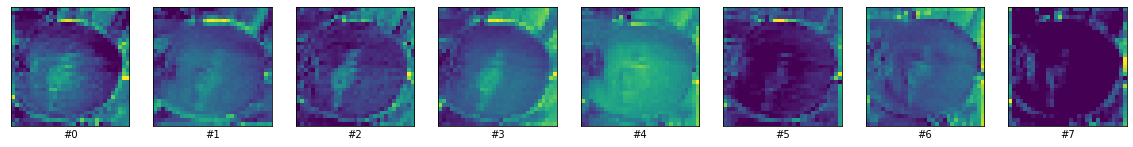

target_datasets/val/half/IMG_1072.jpg


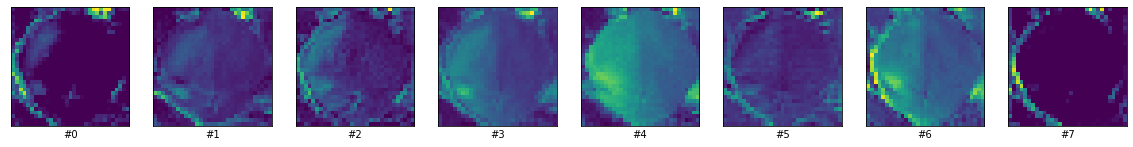

In [ ]:
visualize.vis_hidden_layer('incorrect.txt', 'max_pooling2d', IMAGE_SIZE)